In [30]:
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc, roc_auc_score
from skimage.transform import resize
import scikitplot as skplt
from joblib import dump, load
import matplotlib.pyplot as plt
import numpy as np
import timeit
import seaborn as sns
from scipy import interp
from itertools import cycle
import os
from sklearn.feature_selection import univariate_selection


## Data Preparation


### Functions to transform, resize, inspect and save data


#### Convert images to grayscale, and resize to 50x50 

In [37]:
def transform_images(grayscale=True):
    """ convert color images to grayscale, resize"""
    infected = (image for image in os.listdir('Parasitized'))
    uninfected = (image for image in os.listdir('Uninfected'))
    data = []
    labels = []
    for idx, img in enumerate(infected):
        if grayscale:
            image = cv2.imread('./Parasitized/' + img, cv2.IMREAD_GRAYSCALE)
        else:
            image = cv2.imread('./Parasitized/' + img)
        resize_img = resize(image, (50,50))
        data.append(resize_img)
        labels.append(1)

    for idx, img in enumerate(uninfected):
        if grayscale:
            image = cv2.imread('./Uninfected/' + img, cv2.IMREAD_GRAYSCALE)
        else:
            image = cv2.imread('./Uninfected/' + img)
        resize_img = resize(image, (50,50))
        data.append(resize_img)
        labels.append(0)
    
    cells = np.array(data).astype('float32')
    labels = np.array(labels).astype('int32')
    
    return cells, labels


#### inspect images

In [32]:
def inspect_images(cells, labels):
    plt.figure(1, figsize=(5,5))
    for i in range(25):
        random_image = np.random.randint(0, cells.shape[0], 1)
        plt.subplot(5, 5, i+1)
        plt.subplots_adjust(hspace=0.5, wspace=0.5)
        plt.imshow(cells[random_image][0], cmap='gray')
        plt.title('{}'.format('Infected' if labels[random_image[0]] == 1 else 'Unifected'))
        plt.xticks([]), plt.yticks([])
    plt.show()
    

#### call functions to transform images to grayscale, resize, and save to disk

In [38]:
cells, labels = transform_images()


In [43]:
cells.shape

(27558, 50, 50)

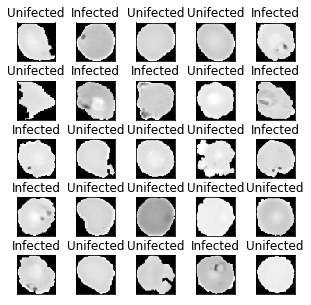

In [41]:
inspect_images(cells,labels)

In [49]:
save_data(cells,labels)


## Feature Engineering: Create histogram of grayscale intensity vectors
+ darker spots in the images are indicative of malaria; use this as a feature to classify images

In [4]:
def create_histogram_vectors(grayscale_data):
    """ bin the pixel values into 10 bins and normalize the bin counts to 0 - 1 """
    hist = np.zeros((grayscale_data.shape[0],10))  # initialize 2dim array of nrow(grayscale_image) x 10
    for  idx, image_data in enumerate(grayscale_data):
        counts, bins = np.histogram(image_data, bins=10, range=(0.1,1))  # range excludes 0.0--black background pixels
        hist[idx] = counts / np.sum(counts)  # normalize by the sum of all the values to get a value between 0 - 1
    hist = hist.astype('float32')
    return hist


#### Discretize pixel intensity into bins 

In [5]:
hist_features = create_histogram_vectors(cells)


#### Create train and validation

In [6]:
train_x, test_x, train_y, test_y = train_test_split(hist_features, labels, train_size=0.9, test_size=0.1, random_state=155)


In [ ]:
pre_process = StandardScaler()
pre_process.fit(train_x)
train_x_stand = pre_process.transform(train_x)

pca = PCA()
pca.fit(train_x_stand)
fig, ax = plt.subplots()  # plot just one subplot
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_title('Variance Explained by Principal Components')
plt.show()


## Build pipeline to gridsearch SVM parameters
+ gridsearch over the 'C'; higher C attempts classify more data points
+ gridsearch over 'gamma'; higher gamma maximizes the hyperplane margin/distance between classes
+ gridsearch with 3 cross-validated folds
+ run PCA during each iteration to choose the best features


In [7]:
def grid_search():
    standardized_data = StandardScaler()
    pca = PCA(n_components=7)
    svc = SVC()
    pipe = Pipeline([('standardized_data', standardized_data),
                     ('pca', pca),
                     ('svc', svc)])
    
    start = timeit.default_timer()
    svm_parameters = [{'svc__C':[0.1,1.,10.,100.], 'svc__kernel':['rbf'], 'svc__gamma':[0.1,1.,10.,100.], 
                       'svc__probability':[True], 'svc__random_state':[155]}]  
    grid_search_svm = GridSearchCV(pipe, svm_parameters, cv=5, n_jobs=4)
    grid_search_svm.fit(train_x, train_y)
    print(f'Runtime for SVM:{timeit.default_timer() - start}')
    return grid_search_svm


#### fit grid search pipeline to the data

In [8]:
svm_model = grid_search()


Runtime for SVM:3816.581784


{'svc__C': 100.0,
 'svc__gamma': 0.1,
 'svc__kernel': 'rbf',
 'svc__probability': True,
 'svc__random_state': 155}

#### print best performing model

In [12]:
svm_model.best_params_


{'svc__C': 100.0,
 'svc__gamma': 0.1,
 'svc__kernel': 'rbf',
 'svc__probability': True,
 'svc__random_state': 155}

#### Plot Params vs Accuracy

In [51]:
def plot_scores():
    scores = svm_model.cv_results_['mean_test_score']
    params = svm_model.cv_results_['params']
    model_config = []
    # append tuples of params and score
    for i in range(len(params)):
        model_config.append((params[i]['svc__C'], params[i]['svc__gamma'], scores[i]))
    
    # sort on score
    s_model_config = sorted(model_config, key=lambda x:x[2], reverse=True)
    for config in s_model_config:
        print('C: {:<10} Gamma: {:<10} Score: {:.3f}'.format(config[0], config[1], config[2]))
plot_scores()


C: 100.0      Gamma: 0.1        Score: 0.836
C: 10.0       Gamma: 0.1        Score: 0.830
C: 10.0       Gamma: 1.0        Score: 0.826
C: 1.0        Gamma: 1.0        Score: 0.823
C: 100.0      Gamma: 1.0        Score: 0.816
C: 1.0        Gamma: 0.1        Score: 0.810
C: 0.1        Gamma: 1.0        Score: 0.784
C: 1.0        Gamma: 10.0       Score: 0.783
C: 0.1        Gamma: 0.1        Score: 0.772
C: 10.0       Gamma: 10.0       Score: 0.765
C: 100.0      Gamma: 10.0       Score: 0.752
C: 0.1        Gamma: 10.0       Score: 0.689
C: 10.0       Gamma: 100.0      Score: 0.654
C: 100.0      Gamma: 100.0      Score: 0.654
C: 1.0        Gamma: 100.0      Score: 0.645
C: 0.1        Gamma: 100.0      Score: 0.501


In [21]:
svm_model.cv_results_['rank_test_score']


array([ 9,  7, 12, 16,  6,  4,  8, 15,  2,  3, 10, 13,  1,  5, 11, 13],
      dtype=int32)

#### Pickle model to disk

In [52]:
save_model(svm_model, 'svm_model')


In [9]:
svm_results = svm_model.predict(test_x)
print(f"Accuracy: {accuracy_score(test_y, svm_results)}")
print(f"Recall: {recall_score(test_y, svm_results)}")
print(classification_report(test_y, svm_results))


Accuracy: 0.8320029027576198
Recall: 0.8233995584988962
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1397
           1       0.83      0.82      0.83      1359

   micro avg       0.83      0.83      0.83      2756
   macro avg       0.83      0.83      0.83      2756
weighted avg       0.83      0.83      0.83      2756



#### ROC AUC Curve

In [1]:
def plot_roc(probs, label):
    fpr = {}
    tpr = {}
    roc_auc = {}
    # results = [n for n in np.ravel(test_y) if n == label]
    for i in range(2):  #  binary classifier
        fpr[i], tpr[i], _ = roc_curve(test_y, probs[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        print(roc_auc[i])
        

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(test_y.ravel(), svm_results.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    fig, ax = plt.subplots()
    ax.plot(fpr[label], tpr[label], color='darkorange', lw=2, label='ROC curve {:.2f}'.format(roc_auc[label]))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()


In [11]:
predict_prob = svm_model.predict_proba(test_x)

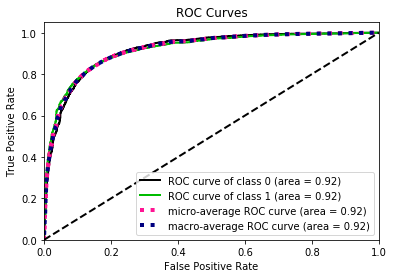

In [11]:
skplt.metrics.plot_roc(test_y, predict_prob)
plt.show()


#### Plot roc curve for 'Uninfected' cases

0.08120648912057958
0.9187935108794203


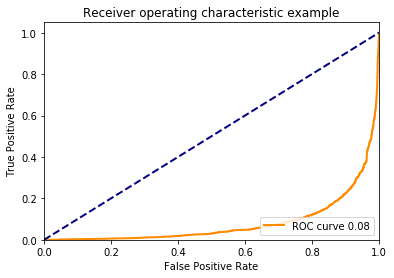

In [15]:
plot_roc(predict_prob,0)


#### Plot roc curve for 'Infected' cases

0.08120648912057958
0.9187935108794203


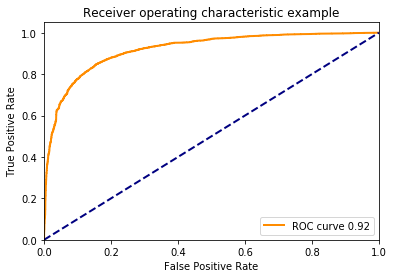

In [16]:
plot_roc(predict_prob,1)


#### Confusion Matrix heatmap

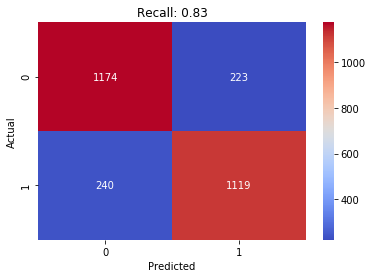

In [10]:
plt.figure()
cm = confusion_matrix(test_y, svm_results)
TN, FN, FP, TP = cm.ravel()
recall = TP / (TP + FN)
sns.heatmap(cm, annot=True, fmt=".0f", cmap=plt.cm.coolwarm)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Recall: {:.2f}'.format(recall))
plt.show()
